# Navigation

[Setup](#install-and-import-all-packages)

[VGG16 Training Experiment](#train-vgg16-on-cifar10-dataset)

[ResNet34 Training Experiment #1](#train-resnet34-for-the-first-time-on-cifar10-dataset)

[ResNet34 Training Experiment #2](#train-resnet34-for-the-second-time-on-cifar10-dataset)

[ResNet34 Training Experiment #3](#train-resnet34-for-the-third-time-on-cifar10-dataset)

[YOLOv8 (n) Training Experiment #1](#train-yolov8n-for-the-first-time-on-cifar10-dataset)

[YOLOv8 (n) Training Experiment #2](#train-yolov8n-for-the-second-time-on-cifar10-dataset)

### Install and import all packages

In [1]:
!pip install --quiet timm
!pip install --quiet jupyterlab-widgets
!pip install --quiet ipywidgets
!pip install --quiet lightning
!pip install --quiet seaborn
!pip install --quiet tabulate
!pip install --quiet ultralytics

import timm
import torch
import pandas as pd
import matplotlib.pyplot as plt

import lightning as L
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns
import tabulate
from IPython.display import HTML, display
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from ultralytics import YOLO
from PIL import Image
from time import time

import os

### Initialize VGG16 model

In [13]:
vgg = timm.create_model('vgg16', pretrained=True, num_classes=10)

### Initialize ResNet34 Model

In [14]:
resnet = timm.create_model('resnet34', pretrained=True, num_classes=10)

In [22]:
L.seed_everything(40)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Seed set to 40


### Specify dataset and checkpoint paths

In [23]:
DATASET_PATH = './data'
CHECKPOINT_PATH = 'runs'

### Download CIFAR10 dataset

In [26]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
data_mean = (train_dataset.data / 255.0).mean(axis=(0, 1, 2))
data_std = (train_dataset.data / 255.0).std(axis=(0, 1, 2))

Files already downloaded and verified


### Augment data

In [27]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std),
    ]
)

# No data augmentation for testing
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(data_mean, data_std)])

### Initialize training, validation, and testing sets 

In [28]:
train_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)

# Note that validation dataset doesn't use augmentations applied to the training dataset
val_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)

train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

test_set = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True) 

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Initialize dataloaders

In [29]:
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

### Declare CIFARModule (module will be slightly adjusted later)

In [135]:
class CIFARModule(L.LightningModule):
    def __init__(self, model, model_hparams, optimizer_hparams):
        """
        model: PyTorch model that you plan to train
        model_hparams: Model hyperparameters, e.g., dropout, activation functions, etc.
                       Not used in this example.
        optimizer_hparams: Optimizer hyperparameters, e.g., learning rate, etc.
        """
        super().__init__()

        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()  
        self.model = model
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.get_classifier().parameters():
            param.requires_grad = True
        #for param in self.model.global_pool.parameters():
        #    param.requires_grad = True                         # extra layers/parameters unfrozen for ResNet34 training run 3
        #for param in self.model.layer4.parameters():
        #    param.requires_grad = True
        
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32) 

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        #
        # IMPORTANT
        #
        # Note that we are only passing classifiers parameters to the optimizer,
        # since we do not need to update the weights of the model backbone
        #
        optimizer = optim.AdamW(self.model.get_classifier().parameters(), **self.hparams.optimizer_hparams)

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        self.log("train_loss", loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

### Define model training function 

In [33]:
def train_model(model, num_epochs, save_name, pretrained_file_path='', **kwargs):

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        # How many epochs to train for if no patience is set
        max_epochs=num_epochs,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name, pretrained_file_path)
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        print(pretrained_filename)
        # Automatically loads the model with the saved hyperparameters
        lightning_model = CIFARModule.load_from_checkpoint(pretrained_filename)
    else:
        print("No checkpoint found")
        L.seed_everything(40)  # To be reproducible
        lightning_model = CIFARModule(model, **kwargs)
        trainer.fit(lightning_model, train_loader, val_loader)
        lightning_model = CIFARModule.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(lightning_model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(lightning_model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

### Define classify function that makes prediction on test images

In [177]:
def classify(image_files_list, current_model):
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    print('Classification results: ')
    
    images, labels = next(image_files_list)
    
    grd_truth_classes = [classes[labels[j]] for j in range(10)]     # prediction to be made on 10 different images

    start = time()
    outputs = current_model(images)
    end = time()

    _, predicted = torch.max(outputs, 1)
    prd_classes = [classes[predicted[j]] for j in range(10)]

    for i in range(10):
        print(f'{i + 1}. {grd_truth_classes[i]} {prd_classes[i]}')

    print('Elapsed inference time:', end-start, 'seconds.')

# Train ResNet34 for the first time on CIFAR10 dataset
#### All layers frozen except for classification head

### Begin training

In [35]:
model_hparams = {}
optimizer_hparams = {"lr": 1e-3, "weight_decay": 1e-4}

num_epochs = 20
save_name = 'resnet1'

model, result = train_model(resnet, num_epochs, save_name, model_hparams=model_hparams, optimizer_hparams=optimizer_hparams) 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Seed set to 40
c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


No checkpoint found


Missing logger folder: runs\resnet1\lightning_logs

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | ResNet           | 21.3 M | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
5.1 K     Trainable params
21.3 M    Non-trainable params
21.3 M    Total params
85.159    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

### Result of inference on testing and validation set

In [52]:
result

{'test': 0.4262999892234802, 'val': 0.43560001254081726}

### Display validation acuracy

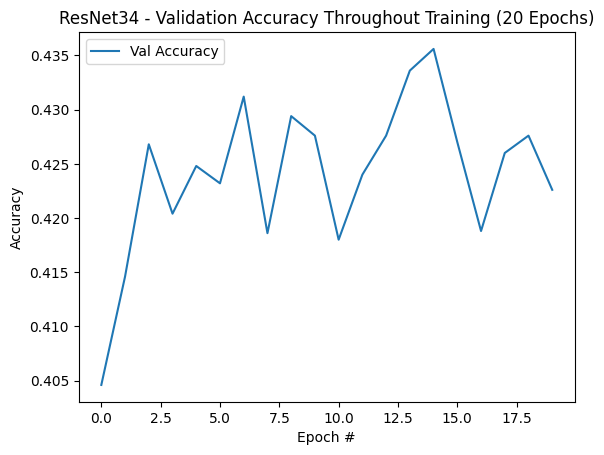

In [113]:
METRICS_PATH = os.path.join('runs', 'resnet1', 'lightning_logs', 'version_0', 'metrics.csv')

data = pd.read_csv(METRICS_PATH)

data = data.loc[data['val_acc'].notna()]    # retrieve val_acc data

x = data['epoch']           
y = data['val_acc']
plt.plot(x, y)
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title('ResNet34 - Validation Accuracy Throughout Training (20 Epochs)')
plt.legend(['Val Accuracy'])
plt.show()

### Make predictions

In [149]:
dataiter = iter(test_loader)
classify(dataiter, model)

Classification results: 
1. cat dog
2. ship ship
3. ship ship
4. plane plane
5. frog deer
6. frog deer
7. car plane
8. frog deer
9. cat bird
10. car cat
Elapsed inference time: 0.15943527221679688 seconds.


# Train ResNet34 for the second time on CIFAR10 dataset
#### All layers frozen except for classification head. More layers added to classification head.

In [ ]:
num_in_features = resnet.get_classifier().in_features

resnet.fc = nn.Sequential(          # modify fc layer to instead be sequence of layers 
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features=num_in_features, out_features=1024, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.5),
    nn.Linear(in_features=1024, out_features=10, bias=True),
)

### Begin training

In [98]:
model_hparams = {}
optimizer_hparams = {"lr": 1e-3, "weight_decay": 1e-4}

num_epochs = 5 
save_name = 'resnet2'
# this model was trained on top of a different model (not the one trained above) trained for 5 epochs (continuation of training up to 10 epochs)
resnet_new_model_2, resnet_result_2 = train_model(resnet_new_model_2, num_epochs, save_name, model_hparams=model_hparams, optimizer_hparams=optimizer_hparams) 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 40
c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


No checkpoint found



  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | ResNet           | 21.8 M | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
538 K     Trainable params
21.3 M    Non-trainable params
21.8 M    Total params
87.293    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

### Result of inference on testing and validation set

In [101]:
resnet_result_2

{'test': 0.4336000084877014, 'val': 0.45980000495910645}

### Display validation acuracy

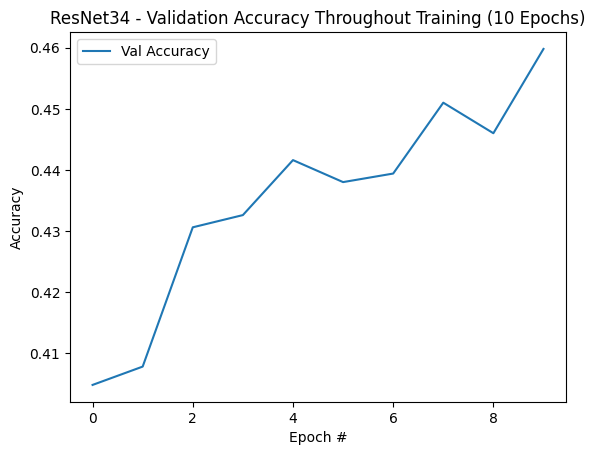

In [112]:
# combine two models that were trained on top of each other (continuation of training)
METRICS_PATH_1 = os.path.join('runs', 'resnet2', 'lightning_logs', 'version_0', 'metrics.csv')
METRICS_PATH_2 = os.path.join('runs', 'resnet2', 'lightning_logs', 'version_1', 'metrics.csv')

data = pd.read_csv(METRICS_PATH_1)
data_2 = pd.read_csv(METRICS_PATH_2)

final_data = pd.concat([data, data_2], ignore_index=True, sort=False)

final_data = final_data.loc[final_data['val_acc'].notna()]   # retrieve val_acc data

x = final_data['epoch']           
y = final_data['val_acc']
plt.plot(x, y)
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title('ResNet34 - Validation Accuracy Throughout Training (10 Epochs)')
plt.legend(['Val Accuracy'])
plt.show()

### Make predictions

In [150]:
dataiter = iter(test_loader)
classify(dataiter, resnet_new_model_2)

Classification results: 
1. cat car
2. ship ship
3. ship ship
4. plane cat
5. frog deer
6. frog frog
7. car car
8. frog deer
9. cat bird
10. car cat
Elapsed inference time: 0.16089224815368652 seconds.


# Train ResNet34 for the third time on CIFAR10 dataset
#### All layers frozen except for classification head, global pool, and layer4. More layers added to classification head.

##### Notice the extra layers unfrozen near the bottom of the code (everything commented out for demonstration purposes)

In [181]:
#class CIFARModule(L.LightningModule):
#    def __init__(self, model, model_hparams, optimizer_hparams):
#        """
#        model: PyTorch model that you plan to train
#        model_hparams: Model hyperparameters, e.g., dropout, activation functions, etc.
#                       Not used in this example.
#        optimizer_hparams: Optimizer hyperparameters, e.g., learning rate, etc.
#        """
#        super().__init__()
#
#        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
#        self.save_hyperparameters()  
#        self.model = model
#        for param in self.model.parameters():
#            param.requires_grad = False
#        for param in self.model.get_classifier().parameters():
#            param.requires_grad = True
#        #for param in self.model.global_pool.parameters():
#        #    param.requires_grad = True                         # extra layers/parameters unfrozen for ResNet34 training run 3
#        #for param in self.model.layer4.parameters():
#        #    param.requires_grad = True

### Begin training

In [136]:
model_hparams = {}
optimizer_hparams = {"lr": 1e-3, "weight_decay": 1e-4}

num_epochs = 5
save_name = 'resnet3'
# CIFARModule was updated at this point to include additonal unfrozen layers in training
resnet_new_model_3, resnet_result_3 = train_model(resnet_new_model_2, num_epochs, save_name, model_hparams=model_hparams, optimizer_hparams=optimizer_hparams)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 40
c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


No checkpoint found


Missing logger folder: runs\resnet3\lightning_logs

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | ResNet           | 21.8 M | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
13.7 M    Trainable params
8.2 M     Non-trainable params
21.8 M    Total params
87.293    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

### Result of inference on testing and validation set

In [139]:
resnet_result_3

{'test': 0.43529999256134033, 'val': 0.45579999685287476}

### Display validation acuracy

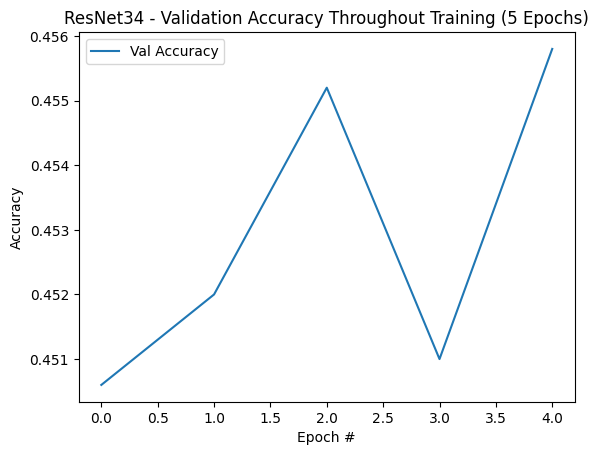

In [151]:
METRICS_PATH = os.path.join('runs', 'resnet3', 'lightning_logs', 'version_0', 'metrics.csv')

data = pd.read_csv(METRICS_PATH)

data = data.loc[data['val_acc'].notna()]  # retrieve val_acc data

x = data['epoch']           
y = data['val_acc']
plt.plot(x, y)
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title('ResNet34 - Validation Accuracy Throughout Training (5 Epochs)')
plt.legend(['Val Accuracy'])
plt.show()

### Make predictions

In [156]:
dataiter = iter(test_loader)
classify(dataiter, resnet_new_model_3)

Classification results: 
1. cat cat
2. ship ship
3. ship ship
4. plane cat
5. frog deer
6. frog frog
7. car car
8. frog bird
9. cat deer
10. car dog
Elapsed inference time: 0.1368088722229004 seconds.


# Train VGG16 on CIFAR10 dataset
#### All layers frozen except for classification head.

### Begin training

In [41]:
save_name = 'vgg1'
num_epochs = 5

vgg_new_model, vgg_result = train_model(vgg, num_epochs, save_name, pretrained_file_path, model_hparams=model_hparams, optimizer_hparams=optimizer_hparams)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model at runs\vgg1\lightning_logs\version_0\checkpoints\epoch=4-step=1755.ckpt, loading...
runs\vgg1\lightning_logs\version_0\checkpoints\epoch=4-step=1755.ckpt


c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\Users\Ashar\anaconda3\envs\visionenv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

### Result of inference on testing and validation set

In [51]:
vgg_result

{'test': 0.6319000124931335, 'val': 0.7006000280380249}

### Display validation acuracy

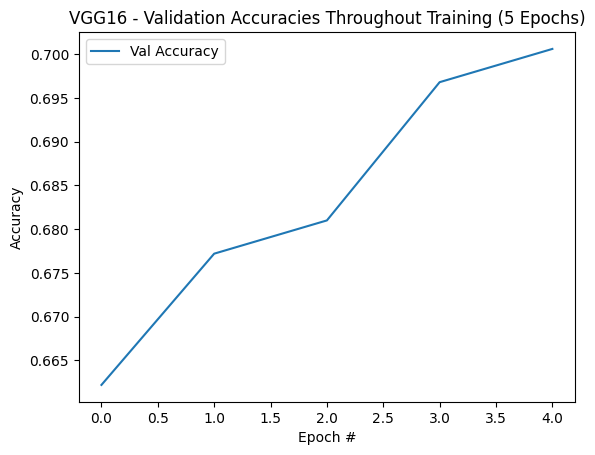

In [94]:
METRICS_PATH = os.path.join('runs', 'vgg1', 'lightning_logs', 'version_0', 'metrics.csv')

data = pd.read_csv(METRICS_PATH)

data = data.loc[data['val_acc'].notna()]   # retrieve val_acc data

x = data['epoch']           
y = data['val_acc']
plt.plot(x, y)
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title('VGG16 - Validation Accuracies Throughout Training (5 Epochs)')
plt.legend(['Val Accuracy'])
plt.show()

### Make predictions

In [157]:
dataiter = iter(test_loader)
classify(dataiter, vgg_new_model)

Classification results: 
1. cat cat
2. ship ship
3. ship ship
4. plane ship
5. frog frog
6. frog deer
7. car car
8. frog frog
9. cat cat
10. car truck
Elapsed inference time: 1.845388650894165 seconds.


# Train YOLOv8n for the first time on CIFAR10 dataset

### Initilize pre-trained YOLOv8n model

In [168]:
yolo = YOLO('yolov8n-cls.pt')

### Begin training

In [169]:
# CIFAR10 dataset was downloaded through ultralytics
results = yolo.train(data='cifar10', epochs=100, imgsz=32) # train for 100 epochs

New https://pypi.org/project/ultralytics/8.1.43 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.30 🚀 Python-3.11.5 torch-2.2.0 CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=cifar10, epochs=100, time=None, patience=100, batch=16, imgsz=32, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

100%|██████████| 140M/140M [01:26<00:00, 1.69MB/s] 
Unzipping C:\Users\Ashar\Documents\Vision\lab4\cifar10.zip to C:\Users\Ashar\Documents\Vision\lab4\cifar10...: 100%|██████████| 60023/60023 [02:02<00:00, 488.88file/s]

Dataset download success ✅ (211.7s), saved to C:\Users\Ashar\Documents\Vision\lab4\cifar10



train: C:\Users\Ashar\Documents\Vision\lab4\cifar10\train... found 50000 images in 10 classes ✅ 
val: None...
test: C:\Users\Ashar\Documents\Vision\lab4\cifar10\test... found 10000 images in 10 classes ✅ 
Overriding model.yaml nc=1000 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Con

train: Scanning C:\Users\Ashar\Documents\Vision\lab4\cifar10\train... 50000 images, 0 corrupt: 100%|██████████| 50000/50000 [00:06<00:00, 8236.06it/s]


train: New cache created: C:\Users\Ashar\Documents\Vision\lab4\cifar10\train.cache


val: Scanning C:\Users\Ashar\Documents\Vision\lab4\cifar10\test... 10000 images, 0 corrupt: 100%|██████████| 10000/10000 [00:01<00:00, 8166.84it/s]


val: New cache created: C:\Users\Ashar\Documents\Vision\lab4\cifar10\test.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 32 train, 32 val
Using 0 dataloader workers
Logging results to runs\classify\train
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100         0G      1.932         16         32: 100%|██████████| 3125/3125 [05:09<00:00, 10.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:14<00:00, 22.33it/s]

                   all       0.48      0.925



      Epoch    GPU_mem       loss  Instances       Size


      2/100         0G      1.811         16         32: 100%|██████████| 3125/3125 [04:55<00:00, 10.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 25.04it/s]

                   all      0.534      0.931



      Epoch    GPU_mem       loss  Instances       Size


      3/100         0G      1.748         16         32: 100%|██████████| 3125/3125 [04:36<00:00, 11.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 22.44it/s]

                   all      0.589      0.956



      Epoch    GPU_mem       loss  Instances       Size


      4/100         0G       1.47         16         32: 100%|██████████| 3125/3125 [04:49<00:00, 10.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:14<00:00, 22.14it/s]


                   all      0.663      0.969

      Epoch    GPU_mem       loss  Instances       Size


      5/100         0G      1.356         16         32: 100%|██████████| 3125/3125 [04:42<00:00, 11.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 22.71it/s]

                   all      0.678      0.975



      Epoch    GPU_mem       loss  Instances       Size


      6/100         0G      1.303         16         32: 100%|██████████| 3125/3125 [04:41<00:00, 11.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 22.48it/s]

                   all      0.709      0.977



      Epoch    GPU_mem       loss  Instances       Size


      7/100         0G      1.271         16         32: 100%|██████████| 3125/3125 [04:41<00:00, 11.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:14<00:00, 22.33it/s]

                   all      0.711       0.98



      Epoch    GPU_mem       loss  Instances       Size


      8/100         0G      1.261         16         32: 100%|██████████| 3125/3125 [04:43<00:00, 11.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.22it/s]

                   all      0.692      0.979



      Epoch    GPU_mem       loss  Instances       Size


      9/100         0G      1.257         16         32: 100%|██████████| 3125/3125 [04:46<00:00, 10.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 22.97it/s]

                   all      0.709       0.98



      Epoch    GPU_mem       loss  Instances       Size


     10/100         0G      1.263         16         32: 100%|██████████| 3125/3125 [04:42<00:00, 11.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.80it/s]

                   all      0.702       0.98



      Epoch    GPU_mem       loss  Instances       Size


     11/100         0G       1.24         16         32: 100%|██████████| 3125/3125 [04:47<00:00, 10.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.56it/s]

                   all       0.71      0.981



      Epoch    GPU_mem       loss  Instances       Size


     12/100         0G      1.227         16         32: 100%|██████████| 3125/3125 [04:52<00:00, 10.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.40it/s]

                   all      0.729       0.98



      Epoch    GPU_mem       loss  Instances       Size


     13/100         0G      1.226         16         32: 100%|██████████| 3125/3125 [04:49<00:00, 10.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.28it/s]

                   all      0.733      0.981



      Epoch    GPU_mem       loss  Instances       Size


     14/100         0G      1.239         16         32: 100%|██████████| 3125/3125 [04:38<00:00, 11.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.24it/s]

                   all      0.735      0.982



      Epoch    GPU_mem       loss  Instances       Size


     15/100         0G      1.207         16         32: 100%|██████████| 3125/3125 [04:07<00:00, 12.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 26.92it/s]

                   all      0.736      0.982



      Epoch    GPU_mem       loss  Instances       Size


     16/100         0G      1.193         16         32: 100%|██████████| 3125/3125 [04:04<00:00, 12.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 27.01it/s]

                   all      0.741      0.983



      Epoch    GPU_mem       loss  Instances       Size


     17/100         0G      1.182         16         32: 100%|██████████| 3125/3125 [04:04<00:00, 12.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.60it/s]

                   all      0.747      0.985



      Epoch    GPU_mem       loss  Instances       Size


     18/100         0G       1.17         16         32: 100%|██████████| 3125/3125 [04:47<00:00, 10.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 22.94it/s]

                   all      0.746      0.984



      Epoch    GPU_mem       loss  Instances       Size


     19/100         0G       1.15         16         32: 100%|██████████| 3125/3125 [04:31<00:00, 11.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.76it/s]

                   all      0.745      0.985



      Epoch    GPU_mem       loss  Instances       Size


     20/100         0G      1.153         16         32: 100%|██████████| 3125/3125 [04:25<00:00, 11.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.38it/s]

                   all      0.745      0.985



      Epoch    GPU_mem       loss  Instances       Size


     21/100         0G      1.144         16         32: 100%|██████████| 3125/3125 [04:33<00:00, 11.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.09it/s]

                   all      0.747      0.985



      Epoch    GPU_mem       loss  Instances       Size


     22/100         0G      1.139         16         32: 100%|██████████| 3125/3125 [04:31<00:00, 11.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 25.71it/s]

                   all      0.748      0.985



      Epoch    GPU_mem       loss  Instances       Size


     23/100         0G      1.155         16         32: 100%|██████████| 3125/3125 [04:29<00:00, 11.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.11it/s]

                   all       0.75      0.985



      Epoch    GPU_mem       loss  Instances       Size


     24/100         0G      1.151         16         32: 100%|██████████| 3125/3125 [04:35<00:00, 11.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 25.13it/s]

                   all       0.75      0.985



      Epoch    GPU_mem       loss  Instances       Size


     25/100         0G       1.12         16         32: 100%|██████████| 3125/3125 [04:36<00:00, 11.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 24.04it/s]

                   all      0.748      0.985



      Epoch    GPU_mem       loss  Instances       Size


     26/100         0G       1.11         16         32: 100%|██████████| 3125/3125 [04:35<00:00, 11.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.65it/s]

                   all      0.749      0.985



      Epoch    GPU_mem       loss  Instances       Size


     27/100         0G      1.092         16         32: 100%|██████████| 3125/3125 [04:23<00:00, 11.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.76it/s]

                   all      0.751      0.985



      Epoch    GPU_mem       loss  Instances       Size


     28/100         0G      1.093         16         32: 100%|██████████| 3125/3125 [04:35<00:00, 11.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.82it/s]

                   all      0.752      0.985



      Epoch    GPU_mem       loss  Instances       Size


     29/100         0G      1.134         16         32: 100%|██████████| 3125/3125 [04:24<00:00, 11.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.31it/s]

                   all      0.754      0.985



      Epoch    GPU_mem       loss  Instances       Size


     30/100         0G      1.112         16         32: 100%|██████████| 3125/3125 [04:28<00:00, 11.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 25.28it/s]

                   all      0.755      0.985



      Epoch    GPU_mem       loss  Instances       Size


     31/100         0G      1.105         16         32: 100%|██████████| 3125/3125 [04:33<00:00, 11.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.99it/s]

                   all      0.756      0.986



      Epoch    GPU_mem       loss  Instances       Size


     32/100         0G      1.089         16         32: 100%|██████████| 3125/3125 [04:33<00:00, 11.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.94it/s]

                   all      0.758      0.985



      Epoch    GPU_mem       loss  Instances       Size


     33/100         0G      1.101         16         32: 100%|██████████| 3125/3125 [04:30<00:00, 11.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.87it/s]

                   all      0.758      0.986



      Epoch    GPU_mem       loss  Instances       Size


     34/100         0G      1.108         16         32: 100%|██████████| 3125/3125 [04:31<00:00, 11.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.21it/s]


                   all       0.76      0.986

      Epoch    GPU_mem       loss  Instances       Size


     35/100         0G      1.085         16         32: 100%|██████████| 3125/3125 [04:26<00:00, 11.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.64it/s]

                   all       0.76      0.986



      Epoch    GPU_mem       loss  Instances       Size


     36/100         0G      1.085         16         32: 100%|██████████| 3125/3125 [04:31<00:00, 11.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.50it/s]

                   all      0.761      0.986



      Epoch    GPU_mem       loss  Instances       Size


     37/100         0G      1.099         16         32: 100%|██████████| 3125/3125 [04:36<00:00, 11.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.21it/s]

                   all      0.761      0.987



      Epoch    GPU_mem       loss  Instances       Size


     38/100         0G      1.096         16         32: 100%|██████████| 3125/3125 [04:35<00:00, 11.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.21it/s]

                   all      0.762      0.986



      Epoch    GPU_mem       loss  Instances       Size


     39/100         0G      1.069         16         32: 100%|██████████| 3125/3125 [04:26<00:00, 11.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 25.04it/s]

                   all      0.763      0.986



      Epoch    GPU_mem       loss  Instances       Size


     40/100         0G      1.095         16         32: 100%|██████████| 3125/3125 [04:31<00:00, 11.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 22.44it/s]

                   all      0.765      0.986



      Epoch    GPU_mem       loss  Instances       Size


     41/100         0G      1.078         16         32: 100%|██████████| 3125/3125 [04:33<00:00, 11.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.53it/s]


                   all      0.765      0.986

      Epoch    GPU_mem       loss  Instances       Size


     42/100         0G      1.044         16         32: 100%|██████████| 3125/3125 [04:29<00:00, 11.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.52it/s]

                   all      0.764      0.987



      Epoch    GPU_mem       loss  Instances       Size


     43/100         0G      1.079         16         32: 100%|██████████| 3125/3125 [04:34<00:00, 11.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 25.01it/s]

                   all      0.766      0.986



      Epoch    GPU_mem       loss  Instances       Size


     44/100         0G      1.069         16         32: 100%|██████████| 3125/3125 [04:29<00:00, 11.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:14<00:00, 22.30it/s]

                   all      0.766      0.986



      Epoch    GPU_mem       loss  Instances       Size


     45/100         0G      1.042         16         32: 100%|██████████| 3125/3125 [04:33<00:00, 11.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.64it/s]

                   all      0.765      0.987



      Epoch    GPU_mem       loss  Instances       Size


     46/100         0G      1.039         16         32: 100%|██████████| 3125/3125 [04:23<00:00, 11.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.95it/s]

                   all      0.767      0.987



      Epoch    GPU_mem       loss  Instances       Size


     47/100         0G      1.056         16         32: 100%|██████████| 3125/3125 [04:29<00:00, 11.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.60it/s]

                   all      0.767      0.987



      Epoch    GPU_mem       loss  Instances       Size


     48/100         0G      1.043         16         32: 100%|██████████| 3125/3125 [04:33<00:00, 11.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.81it/s]

                   all      0.768      0.987



      Epoch    GPU_mem       loss  Instances       Size


     49/100         0G      1.032         16         32: 100%|██████████| 3125/3125 [04:29<00:00, 11.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.36it/s]

                   all      0.768      0.987



      Epoch    GPU_mem       loss  Instances       Size


     50/100         0G      1.042         16         32: 100%|██████████| 3125/3125 [04:33<00:00, 11.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.90it/s]

                   all      0.769      0.987



      Epoch    GPU_mem       loss  Instances       Size


     51/100         0G      1.016         16         32: 100%|██████████| 3125/3125 [04:37<00:00, 11.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.25it/s]

                   all       0.77      0.987



      Epoch    GPU_mem       loss  Instances       Size


     52/100         0G      1.041         16         32: 100%|██████████| 3125/3125 [04:26<00:00, 11.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 25.03it/s]

                   all      0.771      0.987



      Epoch    GPU_mem       loss  Instances       Size


     53/100         0G      1.027         16         32: 100%|██████████| 3125/3125 [04:31<00:00, 11.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 22.53it/s]

                   all      0.771      0.987



      Epoch    GPU_mem       loss  Instances       Size


     54/100         0G      1.019         16         32: 100%|██████████| 3125/3125 [04:33<00:00, 11.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.16it/s]

                   all      0.771      0.987



      Epoch    GPU_mem       loss  Instances       Size


     55/100         0G      1.015         16         32: 100%|██████████| 3125/3125 [04:39<00:00, 11.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.36it/s]

                   all      0.773      0.987



      Epoch    GPU_mem       loss  Instances       Size


     56/100         0G      1.007         16         32: 100%|██████████| 3125/3125 [04:23<00:00, 11.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.38it/s]


                   all      0.773      0.987

      Epoch    GPU_mem       loss  Instances       Size


     57/100         0G     0.9933         16         32: 100%|██████████| 3125/3125 [04:26<00:00, 11.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 25.19it/s]

                   all      0.774      0.987



      Epoch    GPU_mem       loss  Instances       Size


     58/100         0G     0.9954         16         32: 100%|██████████| 3125/3125 [04:33<00:00, 11.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.46it/s]

                   all      0.774      0.987



      Epoch    GPU_mem       loss  Instances       Size


     59/100         0G     0.9956         16         32: 100%|██████████| 3125/3125 [04:35<00:00, 11.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.87it/s]

                   all      0.775      0.987



      Epoch    GPU_mem       loss  Instances       Size


     60/100         0G     0.9838         16         32: 100%|██████████| 3125/3125 [04:31<00:00, 11.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 24.01it/s]

                   all      0.775      0.987

      Epoch    GPU_mem       loss  Instances       Size



     61/100         0G     0.9601         16         32: 100%|██████████| 3125/3125 [04:29<00:00, 11.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.83it/s]

                   all      0.777      0.987



      Epoch    GPU_mem       loss  Instances       Size


     62/100         0G     0.9576         16         32: 100%|██████████| 3125/3125 [04:29<00:00, 11.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.20it/s]

                   all      0.778      0.988



      Epoch    GPU_mem       loss  Instances       Size


     63/100         0G     0.9533         16         32: 100%|██████████| 3125/3125 [04:27<00:00, 11.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.14it/s]


                   all      0.779      0.987

      Epoch    GPU_mem       loss  Instances       Size


     64/100         0G     0.9402         16         32: 100%|██████████| 3125/3125 [04:34<00:00, 11.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 22.66it/s]

                   all       0.78      0.987



      Epoch    GPU_mem       loss  Instances       Size


     65/100         0G     0.9423         16         32: 100%|██████████| 3125/3125 [04:22<00:00, 11.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.99it/s]

                   all      0.781      0.988



      Epoch    GPU_mem       loss  Instances       Size


     66/100         0G      0.932         16         32: 100%|██████████| 3125/3125 [04:32<00:00, 11.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 24.06it/s]

                   all      0.781      0.988



      Epoch    GPU_mem       loss  Instances       Size


     67/100         0G     0.9279         16         32: 100%|██████████| 3125/3125 [04:30<00:00, 11.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.84it/s]

                   all      0.781      0.988



      Epoch    GPU_mem       loss  Instances       Size


     68/100         0G     0.9341         16         32: 100%|██████████| 3125/3125 [04:34<00:00, 11.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.57it/s]

                   all      0.782      0.988



      Epoch    GPU_mem       loss  Instances       Size


     69/100         0G      0.913         16         32: 100%|██████████| 3125/3125 [04:33<00:00, 11.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.97it/s]

                   all      0.782      0.988



      Epoch    GPU_mem       loss  Instances       Size


     70/100         0G     0.9181         16         32: 100%|██████████| 3125/3125 [04:27<00:00, 11.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.28it/s]

                   all      0.782      0.988



      Epoch    GPU_mem       loss  Instances       Size


     71/100         0G     0.9121         16         32: 100%|██████████| 3125/3125 [04:36<00:00, 11.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.19it/s]

                   all      0.782      0.988



      Epoch    GPU_mem       loss  Instances       Size


     72/100         0G      0.902         16         32: 100%|██████████| 3125/3125 [05:08<00:00, 10.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:15<00:00, 20.69it/s]

                   all      0.781      0.988



      Epoch    GPU_mem       loss  Instances       Size


     73/100         0G     0.8962         16         32: 100%|██████████| 3125/3125 [05:19<00:00,  9.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:14<00:00, 20.94it/s]


                   all      0.781      0.989

      Epoch    GPU_mem       loss  Instances       Size


     74/100         0G     0.8997         16         32: 100%|██████████| 3125/3125 [05:13<00:00,  9.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:15<00:00, 20.71it/s]

                   all      0.782      0.988



      Epoch    GPU_mem       loss  Instances       Size


     75/100         0G      0.887         16         32: 100%|██████████| 3125/3125 [05:01<00:00, 10.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:15<00:00, 20.71it/s]

                   all      0.782      0.988

      Epoch    GPU_mem       loss  Instances       Size



     76/100         0G      0.892         16         32: 100%|██████████| 3125/3125 [05:06<00:00, 10.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:14<00:00, 22.33it/s]

                   all      0.782      0.988



      Epoch    GPU_mem       loss  Instances       Size


     77/100         0G     0.8885         16         32: 100%|██████████| 3125/3125 [05:00<00:00, 10.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:14<00:00, 21.11it/s]

                   all      0.785      0.989

      Epoch    GPU_mem       loss  Instances       Size



     78/100         0G     0.8827         16         32: 100%|██████████| 3125/3125 [05:28<00:00,  9.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:27<00:00, 11.43it/s]

                   all      0.788      0.989



      Epoch    GPU_mem       loss  Instances       Size


     79/100         0G     0.8678         16         32: 100%|██████████| 3125/3125 [08:53<00:00,  5.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:27<00:00, 11.50it/s]

                   all      0.789      0.989



      Epoch    GPU_mem       loss  Instances       Size


     80/100         0G     0.8715         16         32: 100%|██████████| 3125/3125 [08:49<00:00,  5.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:27<00:00, 11.31it/s]

                   all      0.793      0.989



      Epoch    GPU_mem       loss  Instances       Size


     81/100         0G     0.8613         16         32: 100%|██████████| 3125/3125 [09:11<00:00,  5.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:28<00:00, 11.03it/s]

                   all      0.794      0.989



      Epoch    GPU_mem       loss  Instances       Size


     82/100         0G      0.867         16         32: 100%|██████████| 3125/3125 [09:02<00:00,  5.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:27<00:00, 11.57it/s]

                   all      0.793       0.99



      Epoch    GPU_mem       loss  Instances       Size


     83/100         0G     0.8551         16         32: 100%|██████████| 3125/3125 [09:15<00:00,  5.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:27<00:00, 11.21it/s]

                   all      0.794      0.989



      Epoch    GPU_mem       loss  Instances       Size


     84/100         0G     0.8433         16         32: 100%|██████████| 3125/3125 [04:17<00:00, 12.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 26.53it/s]

                   all      0.795       0.99



      Epoch    GPU_mem       loss  Instances       Size


     85/100         0G     0.8317         16         32: 100%|██████████| 3125/3125 [04:09<00:00, 12.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 28.28it/s]

                   all      0.795      0.989



      Epoch    GPU_mem       loss  Instances       Size


     86/100         0G     0.8282         16         32: 100%|██████████| 3125/3125 [04:11<00:00, 12.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 26.85it/s]

                   all      0.797       0.99



      Epoch    GPU_mem       loss  Instances       Size


     87/100         0G      0.822         16         32: 100%|██████████| 3125/3125 [04:10<00:00, 12.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.25it/s]

                   all      0.798       0.99



      Epoch    GPU_mem       loss  Instances       Size


     88/100         0G     0.8142         16         32: 100%|██████████| 3125/3125 [04:41<00:00, 11.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 26.35it/s]

                   all      0.798       0.99



      Epoch    GPU_mem       loss  Instances       Size


     89/100         0G     0.8086         16         32: 100%|██████████| 3125/3125 [04:36<00:00, 11.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.58it/s]

                   all      0.798       0.99



      Epoch    GPU_mem       loss  Instances       Size


     90/100         0G     0.7997         16         32: 100%|██████████| 3125/3125 [04:31<00:00, 11.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 25.22it/s]

                   all      0.798       0.99



      Epoch    GPU_mem       loss  Instances       Size


     91/100         0G     0.7946         16         32: 100%|██████████| 3125/3125 [04:41<00:00, 11.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 27.23it/s]

                   all      0.798       0.99



      Epoch    GPU_mem       loss  Instances       Size


     92/100         0G     0.7807         16         32: 100%|██████████| 3125/3125 [04:33<00:00, 11.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 27.81it/s]


                   all      0.797       0.99

      Epoch    GPU_mem       loss  Instances       Size


     93/100         0G      0.778         16         32: 100%|██████████| 3125/3125 [04:30<00:00, 11.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.26it/s]

                   all      0.797       0.99



      Epoch    GPU_mem       loss  Instances       Size


     94/100         0G     0.7777         16         32: 100%|██████████| 3125/3125 [04:32<00:00, 11.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 22.94it/s]

                   all      0.795       0.99



      Epoch    GPU_mem       loss  Instances       Size


     95/100         0G     0.7627         16         32: 100%|██████████| 3125/3125 [04:41<00:00, 11.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.91it/s]

                   all      0.794       0.99



      Epoch    GPU_mem       loss  Instances       Size


     96/100         0G      0.766         16         32: 100%|██████████| 3125/3125 [04:41<00:00, 11.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.51it/s]

                   all      0.793      0.989



      Epoch    GPU_mem       loss  Instances       Size


     97/100         0G     0.7556         16         32: 100%|██████████| 3125/3125 [04:40<00:00, 11.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.45it/s]

                   all      0.793      0.989



      Epoch    GPU_mem       loss  Instances       Size


     98/100         0G     0.7395         16         32: 100%|██████████| 3125/3125 [04:21<00:00, 11.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 22.97it/s]

                   all      0.792      0.989



      Epoch    GPU_mem       loss  Instances       Size


     99/100         0G     0.7362         16         32: 100%|██████████| 3125/3125 [04:41<00:00, 11.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 22.96it/s]

                   all      0.792      0.989



      Epoch    GPU_mem       loss  Instances       Size


    100/100         0G     0.7354         16         32: 100%|██████████| 3125/3125 [04:43<00:00, 11.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 22.90it/s]

                   all      0.791      0.988



100 epochs completed in 8.425 hours.
Optimizer stripped from runs\classify\train\weights\last.pt, 3.0MB
Optimizer stripped from runs\classify\train\weights\best.pt, 3.0MB

Validating runs\classify\train\weights\best.pt...
Ultralytics YOLOv8.1.30 🚀 Python-3.11.5 torch-2.2.0 CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
YOLOv8n-cls summary (fused): 73 layers, 1447690 parameters, 0 gradients, 3.3 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: C:\Users\Ashar\Documents\Vision\lab4\cifar10\train... found 50000 images in 10 classes ✅ 
val: None...
test: C:\Users\Ashar\Documents\Vision\lab4\cifar10\test... found 10000 images in 10 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 26.81it/s]


                   all      0.798       0.99
Speed: 0.0ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train
Results saved to runs\classify\train


# Train YOLOv8n for the second time on CIFAR10 dataset

In [170]:
yolo_model = YOLO('yolov8n-cls.pt') 

### Begin training

In [171]:
yolo_results = yolo_model.train(data='cifar10', epochs=20, imgsz=32) # train for 20 epochs

New https://pypi.org/project/ultralytics/8.1.43 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.30 🚀 Python-3.11.5 torch-2.2.0 CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=cifar10, epochs=20, time=None, patience=100, batch=16, imgsz=32, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning C:\Users\Ashar\Documents\Vision\lab4\cifar10\train... 50000 images, 0 corrupt: 100%|██████████| 50000/50000 [00:00<?, ?it/s]
val: Scanning C:\Users\Ashar\Documents\Vision\lab4\cifar10\test... 10000 images, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 32 train, 32 val
Using 0 dataloader workers
Logging results to runs\classify\train2
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:14<00:00, 22.03it/s]

                   all       0.48      0.925



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.08it/s]

                   all      0.518       0.93



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 26.09it/s]


                   all      0.614      0.955

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 26.29it/s]

                   all       0.66      0.969



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.72it/s]

                   all      0.678      0.976



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 26.34it/s]


                   all      0.711      0.977

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.72it/s]


                   all      0.718       0.98

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 25.61it/s]

                   all      0.722       0.98



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 27.35it/s]

                   all      0.738      0.981



      Epoch    GPU_mem       loss  Instances       Size


      10/20         0G      1.118         16         32: 100%|██████████| 3125/3125 [04:27<00:00, 11.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 25.78it/s]

                   all      0.743      0.982



      Epoch    GPU_mem       loss  Instances       Size


      11/20         0G      1.116         16         32: 100%|██████████| 3125/3125 [04:18<00:00, 12.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.54it/s]

                   all      0.752      0.983



      Epoch    GPU_mem       loss  Instances       Size


      12/20         0G      1.079         16         32: 100%|██████████| 3125/3125 [04:30<00:00, 11.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 25.45it/s]


                   all      0.754      0.984

      Epoch    GPU_mem       loss  Instances       Size


      13/20         0G      1.046         16         32: 100%|██████████| 3125/3125 [04:12<00:00, 12.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:11<00:00, 26.26it/s]


                   all      0.762      0.986

      Epoch    GPU_mem       loss  Instances       Size


      14/20         0G      1.042         16         32: 100%|██████████| 3125/3125 [04:39<00:00, 11.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.22it/s]

                   all      0.765      0.986



      Epoch    GPU_mem       loss  Instances       Size


      15/20         0G      1.006         16         32: 100%|██████████| 3125/3125 [04:42<00:00, 11.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.78it/s]

                   all      0.768      0.986



      Epoch    GPU_mem       loss  Instances       Size


      16/20         0G     0.9788         16         32: 100%|██████████| 3125/3125 [04:36<00:00, 11.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.25it/s]


                   all      0.772      0.987

      Epoch    GPU_mem       loss  Instances       Size


      17/20         0G     0.9656         16         32: 100%|██████████| 3125/3125 [04:28<00:00, 11.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.93it/s]

                   all      0.776      0.987



      Epoch    GPU_mem       loss  Instances       Size


      18/20         0G     0.9439         16         32: 100%|██████████| 3125/3125 [04:38<00:00, 11.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 24.06it/s]

                   all       0.78      0.986



      Epoch    GPU_mem       loss  Instances       Size


      19/20         0G     0.9189         16         32: 100%|██████████| 3125/3125 [04:37<00:00, 11.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 23.47it/s]

                   all       0.78      0.987



      Epoch    GPU_mem       loss  Instances       Size


      20/20         0G     0.9109         16         32: 100%|██████████| 3125/3125 [04:30<00:00, 11.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:13<00:00, 24.00it/s]

                   all      0.782      0.986



20 epochs completed in 1.591 hours.
Optimizer stripped from runs\classify\train2\weights\last.pt, 3.0MB
Optimizer stripped from runs\classify\train2\weights\best.pt, 3.0MB

Validating runs\classify\train2\weights\best.pt...
Ultralytics YOLOv8.1.30 🚀 Python-3.11.5 torch-2.2.0 CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)
YOLOv8n-cls summary (fused): 73 layers, 1447690 parameters, 0 gradients, 3.3 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: C:\Users\Ashar\Documents\Vision\lab4\cifar10\train... found 50000 images in 10 classes ✅ 
val: None...
test: C:\Users\Ashar\Documents\Vision\lab4\cifar10\test... found 10000 images in 10 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [00:12<00:00, 24.09it/s]


                   all      0.782      0.986
Speed: 0.0ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train2
Results saved to runs\classify\train2


### Initialize list of test images

In [199]:
images_list = [
    'yolo-test-images/plane.jpg',
    'yolo-test-images/frog.jpg',
    'yolo-test-images/bird.jpg',
    'yolo-test-images/cat.jpg',
    'yolo-test-images/truck.jpg',
    'yolo-test-images/deer.jpg'
]

### Make predictions with the second trained model

In [212]:
IMAGE_RESULTS_FOLDER = 'yolo-test-results'

if not os.path.isdir(IMAGE_RESULTS_FOLDER):
    os.makedirs(IMAGE_RESULTS_FOLDER)

updated_yolo_model_path = os.path.join('runs', 'classify', 'train2', 'weights', 'best.pt') 
updated_yolo_model = YOLO(updated_yolo_model_path)   # initialize updated model

results = updated_yolo_model(images_list)   # make prediction on list of images
for i in range(len(results)):
    results[i].save(filename=os.path.join(IMAGE_RESULTS_FOLDER, 'yolo_result_' + os.path.splitext(os.path.basename(images_list[i]))[0] + '.jpg'))   # save images with probablities to folder


0: 32x32 airplane 0.91, bird 0.08, ship 0.00, deer 0.00, cat 0.00, 1.1ms
1: 32x32 frog 0.99, cat 0.00, bird 0.00, ship 0.00, dog 0.00, 1.1ms
2: 32x32 bird 0.91, airplane 0.03, automobile 0.02, truck 0.01, frog 0.01, 1.1ms
3: 32x32 cat 0.98, dog 0.01, frog 0.01, bird 0.00, deer 0.00, 1.1ms
4: 32x32 horse 0.53, bird 0.26, deer 0.10, dog 0.06, airplane 0.02, 1.1ms
5: 32x32 truck 0.89, automobile 0.05, airplane 0.03, horse 0.02, ship 0.00, 1.1ms
6: 32x32 deer 0.58, airplane 0.13, bird 0.10, dog 0.09, cat 0.07, 1.1ms
Speed: 4.7ms preprocess, 1.1ms inference, 0.0ms postprocess per image at shape (1, 3, 32, 32)
